# Développer son propre classifieur d'images

Dans cette partie, nous allons mettre en place un réseau de neurones convolutif profond pour classifier des images  </br>  selon une thématique arbitraire.

Notre choix se porte sur `la détection automatique des facteurs pouvant conduire à des cas d'accident`. </br>
*Ce système peut servir à déclencher une alerte en cas d'accident afin donc d'avoir réaction
rapide et prévenir le pire.*

Notre travail se divise 4 parties:
- **Collection de données suceptibles de provoquer des accidents**
- **Préparation des données pour l'entraînement**
- **Définition et entraînement du modèle d'apprentissage profond**
- **Prédiction ou déploiement** 

###  Installation des librairies

In [1]:
!pip install torchvision
!pip install -Uqq fastai
!pip install -Uqq fastbook
import fastai, fastbook
fastai.__version__, fastbook.__version__
from torchvision import datasets 

### Importation des librairies 

In [2]:
from fastai.vision.all import *
from fastbook import *

## **Collection de données sur la détection d'accident de voiture **

Nous utiliserons une fonction prédéfinie nommée `search_images_ddg` de `fastbook` permettant de rechercher un </br>
ensemble d'url d'images correspondant à des facteurs suceptible de créer des accidents decirculations </br>
Le moteur utiliser est DuckDuckGo.</br>

Ainsi, il nous faut définir des termes de recherche pertinent pour avoir des images correctes.</br>
Comme il s'agit de la détection de, nous avons deux  facteurs d'accident, nous allons appliquer notre modèle sur certains paramètres </br>

Voici donc les termes de recherche entrées pour chaque cas:
- surcharge de voiture : `car overload`
- mauvaise route: `bad road`
- conducteur au téléphone `driver on the phone`
- voiture en vitesse `fast-moving car`



In [3]:
# Retirer le commentaire ci-dessous et exécuter pour voir le code source de la fonction 
search_images_ddg??

In [4]:
n_images = 200
url_voiture_surcharge = search_images_ddg('car overload', max_images=n_images)
url_mauvaise_route = search_images_ddg('bad road', max_images=n_images)
url_conducteur_telephone = search_images_ddg('driver on the phone', max_images=n_images)
url_voiture_vitesse = search_images_ddg('fast-moving car', max_images=n_images)

url_voiture_surcharge[0], url_mauvaise_route[0], url_conducteur_telephone[0], url_voiture_vitesse[0]

('https://cdn.acidcow.com/content/img/new02/73/58.jpg',
 'https://www.dailyexcelsior.com/wp-content/uploads/2020/07/k-4-4.jpg',
 'https://thumbs.dreamstime.com/z/drivers-making-phone-call-traffic-accident-calls-31864274.jpg',
 'https://thumbs.dreamstime.com/b/fast-moving-car-light-city-night-38721730.jpg')

### Visualisation d'une image de chaque catégorie collectée

In [5]:
from fastdownload import download_url
dest1 = 'sample_data/voiture_surcharge.jpg'
dest2 = 'sample_data/route.jpg'
dest3 = 'sample_data/conducteur_telephone.jpg'
dest4 = 'sample_data/voiture_vitesse.jpg'

download_url(url_voiture_surcharge[0], dest1, show_progress=True)
download_url(url_mauvaise_route[0], dest2, show_progress=True)
download_url(url_conducteur_telephone[0], dest3, show_progress=True)
download_url(url_voiture_vitesse[0], dest4, show_progress=True)

Path('sample_data/voiture_vitesse.jpg')

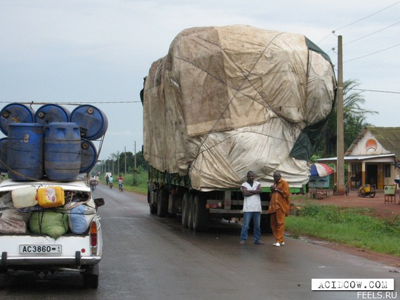

Image montrant surcharge de voiture


In [6]:
im1 = Image.open(dest1)
display(im1.to_thumb(400, 400))
print('Image montrant surcharge de voiture' )

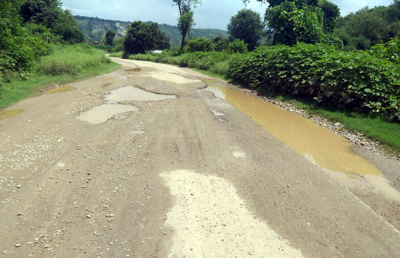

Image montrant une mauvaise route 


In [7]:
im2 = Image.open(dest2)
display(im2.to_thumb(400, 400))
print('Image montrant une mauvaise route ')

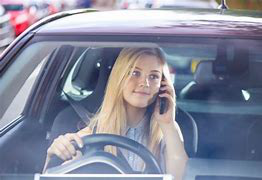

Image montrant un conducteur au téléphone


In [12]:
im3 = Image.open(dest3)
display(im3.to_thumb(400, 400))
print('Image montrant un conducteur au téléphone')

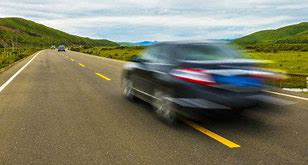

Image montrant une voiture en pleine vitesse


In [13]:
im4 = Image.open(dest4)
display(im4.to_thumb(400, 400))
print('Image montrant une voiture en pleine vitesse')

## Téléchargement des images à partir des urls collectées

Pour cela, nous crééons 5 dossiers:</br>
- `data/`: dossier racine des données
- `data/surcharge_voiture`: sous-dossier des images de surcharges
- `data/mauvaise_route`: sous-dossier des images de mauvaise route</br>
- `data/conducteur_telephone`: sous-dossier des images de conducteur au téléphone</br>
- `data/voiture_vitesse`: sous-dossier des images de voiture en vitesse</br>

Puis, nous téléchargeons les images de chaque catégorie dans leur
sous-dossier correspondant à partir des urls collectées.

In [10]:
! dir; mkdir test; dir

 Le volume dans le lecteur C n'a pas de nom.
 Le num‚ro de s‚rie du volume est 90FF-4605

 R‚pertoire de C:\Users\oniel pc\Desktop\perso\ETUDE\COURS\MASTER 2\Deep Learning\devoir 1 detection de voiture\essaie2


 R‚pertoire de C:\Users\oniel pc\Desktop\perso\ETUDE\COURS\MASTER 2\Deep Learning\devoir 1 detection de voiture\essaie2


 R‚pertoire de C:\Users\oniel pc\Desktop\perso\ETUDE\COURS\MASTER 2\Deep Learning\devoir 1 detection de voiture\essaie2



Fichier introuvable


In [14]:
# Définition du dossier racine des données
root = Path('data') 

# dictionnaire liant le chemin du dossier de chaque catégorie
# à ses urls collectées
path_urls = {root/'surcharge_voiture': url_voiture_surcharge,
             root/'mauvaise_route': url_mauvaise_route,
             root/'conducteur_telephone': url_conducteur_telephone,
             root/'voiture_vitesse': url_voiture_vitesse
            }

for path in path_urls:
    # Créer le dossier spécifique à une classe
    path.mkdir(exist_ok=True, parents=True)
    # Télécharge dans le dossier créé  les images spécifiques à la classe associée
    download_images(path, urls=path_urls[path])
    print(f"Nombre d'images dans {path}: {len(path.ls())}")

Nombre d'images dans data\surcharge_voiture: 567
Nombre d'images dans data\mauvaise_route: 424
Nombre d'images dans data\conducteur_telephone: 381
Nombre d'images dans data\voiture_vitesse: 197


Certaines images téchargées sont malformatées ou corrompues.</br>
Il est donc impossible de les lire. Une fonction prédéfinie encore
dans `fastai` </br>permet de détecter ces images: `verify_images`.

In [15]:
images_not_working = verify_images(get_image_files(root))
images_not_working.map(Path.unlink)
f"Nombre d'images corrompus: {len(images_not_working)}"

"Nombre d'images corrompus: 13"

## **Préparation des données pour l'entraînement**

`fastai` fournit un ensemble de classes et méthodes pour aiser le *pipelining* (chaîne de traitements) des données
nécessaire à son ingestion dans les modèles d'apprentissage  profond de la librairie `PyTorch` développée et maintenue par META, mère de Facebook, (qui passera bientôt à la Fondation Open Source Linux - annonce publique faite par son CEO !)

In [16]:
# Collectionne l'ensemble des fichiers images
# dans le dossier `root` et ses sous-dossiers
fnames = get_image_files(root)

# retourne le nom du dossier parent
# qui est la classe de l'image
def label_function(x): return x.parent.name

print(f"{fnames[0], label_function(fnames[0])}")


dls = ImageDataLoaders.from_path_func(root, fnames, label_function,
                                     valid_pct=0.2, seed=121, bs=32,
                                     item_tfms=Resize(224))

(Path('data/conducteur_telephone/0023635c-c55a-402f-82e5-49679daced5a.jpg'), 'conducteur_telephone')
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


**Rappelon qu'en apprentissage supervisé qui est notre cas, une donnée est formée du couple entrée et sortie: $(x,y)$. </br>Ici $x$ est une image et $y$ est sa catégorie (présence ou absence d'accident). </br> En revanche, en apprentissage non supervisé, une donnée est constituée uniquement de son entrée $x$.**

Ci-dessus est le data loader (`ImageDataLoaders`) dédiée aux entrées de type image.</br>
Il sert principalement à créér un itérateur de données attendu par PyTorch pour entraîner notre modèle.</br> Mais d'autres fonctionalités y sont associées comme la visualisation d'un lot de données.</br>

La [documentation](https://docs.fast.ai/) de fastai est très claire. Elle doit constituer votre compagnon tout au long de cet apprentissage qui ne doit pas se limiter à la période de notre cours !
Pour mieux saisir les portions de code qui suivront, veuillez lire les explications sommaires fournies ici et par la suite consulter la [documentation](https://docs.fast.ai/) pour plus de détails et de possibilités!


Nous allons faire une brève explication des paramètres utilisés dans le code ci-dessus:
- `root` est le chemin vers le dossier racine où se trouve nos données. Dans notre cas, c'est: `data/`
- `fnames` est une abbréviation de `file names` c'est-à-dire les noms (chemin complets) des fichiers représentant nos entrées. Ici, ce sont les fichiers images. Et la fonction `get_image_files` est une fonction flexible prédéfinie dans `fastai` pour collecter les noms des fichiers.
- `label_function` est une fonction permettant de déduire la sortie ou le label à partir du nom de l'entrée. Ici, il s'agit du nom y compris le chemin complet d'un fichier image.
- `valid_pct` est le pourcentage de données sélectionné aléatoirement et mis de côté pour la validation du modèle. Ce concept est si important que même s'il n'est pas spécifié `fastai` le créera pour vous.

- `seed`: il s'agit un nombre pour fixer les données sélectionnées pour la validation à des fins de reproductibilité sinon toute exécution du code engendrera un ensemble de validation différent.
- `bs`: batch size qui est la taille des lots de données qui seront utilisés lors d'une itération d'entraînement du modèle
- `item_tfms` reçoit une ou plus transformation(s) à opérer sur les entrées (items). Ici, nous avons choisi un redimensionnement de la taille des images qui est impératif car elles doivent toutes avoir les mêmes dimensions. 
             

#### Visualisation d'un lot de données

Vous verrez qu'au dessus de chaque image, le nom de la catégorie
est mentionnée.</br>
Cela nous permet d'avoir un aperçu et aussi vérifier l'exactitude des catégories
de notre jeu de données construit.

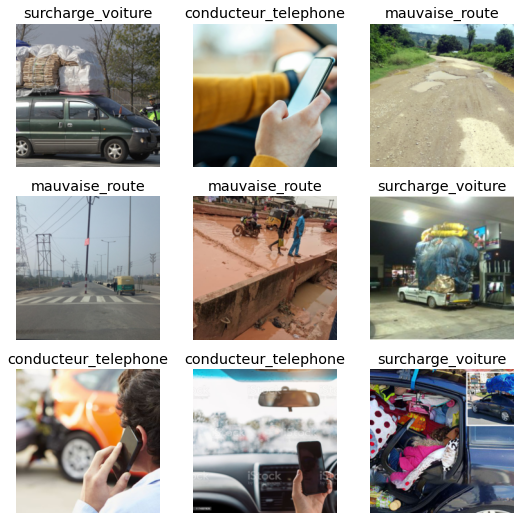

In [17]:
dls.show_batch()

## **Définition et entraînement de notre modèle d'apprentissage profond**

`fastai` a un ensemble de classes et méthodes pour aiser le développement des modèles
profond.

Ces quelques lignes définissent notre modèle et l'entraîne sur 3 époques.

`vision_learner` est une fonction permettant de créér une classe pour apprendre des données de type image principalement.</br> Les paramètres définis sont:
- `` dls``: data loader construit précédemment
- `resnet18`: l'architecture du modèle qui est un réseau convolutif de la famille des ResNet avec une profondeur de 18 couches.
- `metrics`: l'évaluation humaine de la performance du modèle. Ici sa valeur est `error_rate`, fonction prédéfinie dans `fastai` servant à calculer le taux d'erreurs.




In [18]:
#learn = vision_learner.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
learn =  vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Annaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Annaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.903637,0.298931,0.084142,07:15


epoch,train_loss,valid_loss,error_rate,time
0,0.259036,0.174741,0.055016,10:09
1,0.147188,0.157131,0.038835,11:29
2,0.093942,0.145172,0.038835,10:59


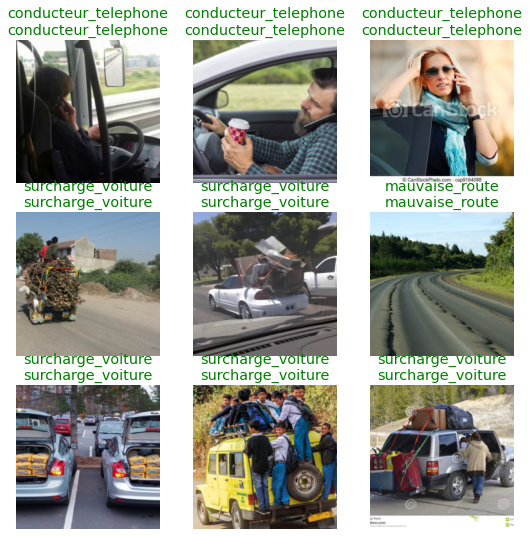

In [28]:
learn.show_results()

## **Utilisation du modèle développé**

Téléchargeons d'autres images et testons-les pour voir.

In [20]:
! pip install wget
! wget https://bit.ly/3THBvXW -to image_test1.jpg
! wget https://bit.ly/3fdcjtl -to image_test2.jpg
! wget https://bit.ly/3NbQuH6 -to image_test3.jpg
! wget https://bit.ly/3sBw94N -to image_test4.jpg

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.
'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.
'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.
'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


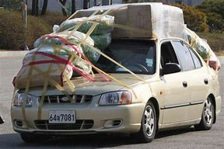

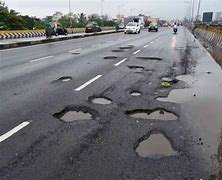

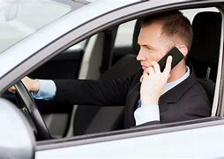

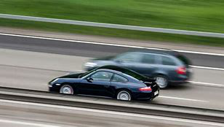

In [21]:
from PIL import Image, ImageDraw

image1 = PILImage.create('image_test1.jpg')
image2 = PILImage.create('image_test2.jpg')
image3 = PILImage.create('image_test3.jpg')
image4 = PILImage.create('image_test4.jpg')

display(image1.to_thumb(224,224))
display(image2.to_thumb(224,224))
display(image3.to_thumb(224,224))
display(image4.to_thumb(224,224))


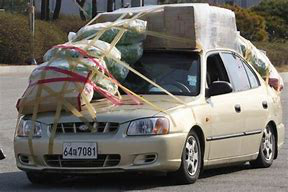

C'est une scène de : surcharge_voiture.
Probabilité que la voiture soit surchargé: 0.9921


In [33]:
display(image1.to_thumb(400,400))
is_fight,_,probs = learn.predict(image1)
print(f"C'est une scène de : {is_fight}.")
print(f"Probabilité que la voiture soit surchargé: {probs[2]:.4f}")

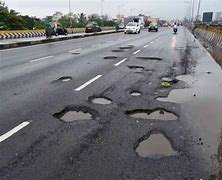

C'est une scène de : mauvaise_route.
Probabilité que la route soit mauvaise': 1.0000


In [34]:
display(image2.to_thumb(400,400))
is_fight,_,probs = learn.predict(image2)
print(f"C'est une scène de : {is_fight}.")
print(f"Probabilité que la route soit mauvaise': {probs[1]:.4f}")

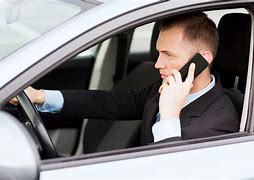

C'est une scène de : conducteur_telephone.
Probabilité que le conducteur soit au téléphone : 1.0000


In [24]:
display(image3.to_thumb(400,400))
is_fight,_,probs = learn.predict(image3)
print(f"C'est une scène de : {is_fight}.")
print(f"Probabilité que le conducteur soit au téléphone : {probs[0]:.4f}")

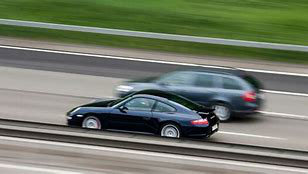

C'est une scène de : voiture_vitesse.
Probabilité que la voiture est en pleine vitesse : 1.0000


In [35]:
display(image4.to_thumb(400,400))
is_fight,_,probs = learn.predict(image4)
print(f"C'est une scène de : {is_fight}.")
print(f"Probabilité que la voiture est en pleine vitesse : {probs[3]:.4f}")

## **Alternativement** 

In [36]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

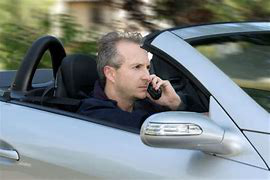

C'est une scène de : conducteur_telephone.
Probabilité d'accident': 0.9991


In [37]:
img1 = PILImage.create(uploader.data[0])
display(img1.to_thumb(400,400))
is_fight,_,probs = learn.predict(img1)
print(f"C'est une scène de : {is_fight}.")
print(f"Probabilité d'accident': {probs[0]:.4f}")

In [38]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

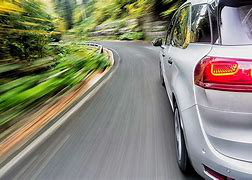

C'est une scène de : voiture_vitesse.
Probabilité d'accident': 0.9856


In [41]:
img2 = PILImage.create(uploader.data[0])
display(img2.to_thumb(400,400))
is_fight,_,probs = learn.predict(img2)
print(f"C'est une scène de : {is_fight}.")
print(f"Probabilité d'accident': {probs[3]:.4f}")

In [42]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

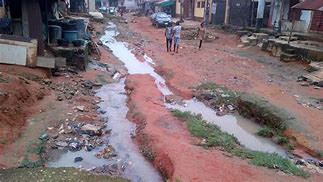

C'est une scène de : mauvaise_route.
Probabilité d'accident': 1.0000


In [44]:
img3 = PILImage.create(uploader.data[0])
display(img3.to_thumb(400,400))
is_fight,_,probs = learn.predict(img3)
print(f"C'est une scène de : {is_fight}.")
print(f"Probabilité d'accident': {probs[1]:.4f}")

In [45]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

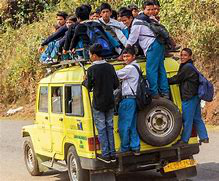

C'est une scène de : surcharge_voiture.
Probabilité d'accident': 0.9976


In [47]:
img4 = PILImage.create(uploader.data[0])
display(img4.to_thumb(400,400))
is_fight,_,probs = learn.predict(img4)
print(f"C'est une scène de : {is_fight}.")
print(f"Probabilité d'accident': {probs[2]:.4f}")